In [1]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.io as pio
from prophet import Prophet

import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)

In [2]:
# To render HTML
pio.renderers.default = "notebook_connected"

In [3]:
dataset = pd.read_csv("elec_dataset.csv", index_col="Date", parse_dates=["Date"])

# Check the last 24 hours
dataset.tail(5)

,Load,Temperature,Cloudiness,Irradiation,PublicHolidays
Date,,,,,
2014-12-09 03:00:00,16457.3,1.3,7.0,0.1,0
2014-12-09 04:00:00,16744.8,-0.1,5.9,0.1,0
2014-12-09 05:00:00,17577.1,-0.1,5.9,0.1,0
2014-12-09 06:00:00,20253.7,-0.1,5.9,0.1,0
2014-12-09 07:00:00,22084.3,-0.2,5.7,0.1,0


### Exploring Data

In [4]:
df = dataset.copy()

# Checking for nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16976 entries, 2013-01-01 00:00:00 to 2014-12-09 07:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Load            16976 non-null  float64
 1   Temperature     16976 non-null  float64
 2   Cloudiness      16976 non-null  float64
 3   Irradiation     16976 non-null  float64
 4   PublicHolidays  16976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 795.8 KB


In [5]:
# Statistical outlook
df.describe()

# Observation
## Ignoring PublicHolidays
## Nothing out of the ordinary

,Load,Temperature,Cloudiness,Irradiation,PublicHolidays
count,16976.000000,16976.000000,16976.000000,16976.000000,16976.000000
mean,18045.582410,9.882805,4.743962,0.597926,0.035344
std,2981.372738,8.065015,1.951630,0.308994,0.184653
min,10494.000000,-14.000000,0.000000,0.100000,0.000000
25%,15559.400000,3.600000,3.300000,0.300000,0.000000
50%,18306.600000,10.500000,4.900000,0.600000,0.000000
75%,20313.425000,15.900000,6.300000,0.900000,0.000000
max,25459.000000,32.200000,8.000000,1.000000,1.000000


#### Vizualization

In [6]:
# Resample by day to get max of PublicHolidays
day_agg = {
    "Load": "mean",
    "Temperature": "mean",
    "Cloudiness": "mean",
    "Irradiation": "mean",
    "PublicHolidays": "max",
}

# Then by week and month to sum PublicHolidays
week_and_month_agg = {
    "Load": "mean",
    "Temperature": "mean",
    "Cloudiness": "mean",
    "Irradiation": "mean",
    "PublicHolidays": "sum",
}
df_by_day = df.resample("D").agg(day_agg)
df_by_week = df_by_day.resample("W").agg(week_and_month_agg)
df_by_month = df_by_day.resample("ME").agg(week_and_month_agg)

In [7]:
def plot_load_timescales(df, df_by_day, df_by_week, df_by_month, var, units="units"):
    fig = make_subplots(
        rows=4, cols=1, subplot_titles=("Hourly", "Daily", "Weekly", "Monthly")
    )

    fig.add_trace(go.Scatter(x=df.index, y=df[var], name="Hourly"), row=1, col=1)
    fig.add_trace(
        go.Scatter(x=df_by_day.index, y=df_by_day[var], name="Daily"), row=2, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_by_week.index, y=df_by_week[var], name="Weekly"), row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=df_by_month.index, y=df_by_month[var], name="Monthly"),row=4,col=1,
    )

    fig.update_layout(height=800, title_text=f"Mean {var}")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text=f"{units}")

    fig.show()


##### Load

In [8]:
plot_load_timescales(df, df_by_day, df_by_week, df_by_month, "Load", "Mhw")

##### Temperature

In [9]:
plot_load_timescales(df, df_by_day, df_by_week, df_by_month, "Temperature")

##### Cloudiness

In [10]:
plot_load_timescales(df, df_by_day, df_by_week, df_by_month, "Cloudiness")

##### Irradiation

In [11]:
plot_load_timescales(df, df_by_day, df_by_week, df_by_month, "Irradiation")

#### Correlation

In [12]:
def plot_monthly_vs_load(var: str, var_units: str = "Units"):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df_by_month.index, y=df_by_month["Load"], name="Load"),
        secondary_y=False,
    )

    fig.add_trace(
        go.Scatter(x=df_by_month.index, y=df_by_month[var], name=var),
        secondary_y=True,
    )

    fig.update_layout(title_text=f"Load vs {var}")
    fig.update_xaxes(title_text="Datetime")
    fig.update_yaxes(title_text="<b> Mhw </b>", secondary_y=False)
    fig.update_yaxes(title_text=f"<b>{var_units}</b>", secondary_y=True)

    fig.show()

##### Load vs Temperature

In [13]:
plot_monthly_vs_load(var="Temperature", var_units="Celsius")

##### Load vs Irradiation

In [14]:
plot_monthly_vs_load(var="Irradiation")

##### Load vs Cloudiness

In [15]:
plot_monthly_vs_load(var="Cloudiness")

##### Load vs Public Holidays

In [16]:
plot_monthly_vs_load(var="PublicHolidays")

In [17]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

last_dec_df = df_by_day.loc["2013-12"]
curr_dec_df = df_by_day.loc["2014-12"]

fig.add_trace(
    go.Scatter(
        x=last_dec_df.index.strftime("%d"), y=last_dec_df["Load"], name="Historic Load"
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=curr_dec_df.index.strftime("%d"), y=curr_dec_df["Load"], name="Current Load"
    ),
    secondary_y=True,
)

fig.update_layout(title_text="2013 Dec vs 2014 Dec (Load)")
fig.update_xaxes(title_text="Datetime")
fig.update_yaxes(title_text="<b> Mhw </b>", secondary_y=False)
fig.update_yaxes(title_text="<b> Mhw </b>", secondary_y=True)

fig.show()

### Test / Train Split

In [18]:
split_datetime = max(df.index) - pd.Timedelta(hours=48)

train = df[:split_datetime]
test = df[split_datetime + pd.Timedelta(hours=1) :]

In [19]:
fig = px.line(
    x=train["2014-11-01":].index,
    y=train["2014-11-01":]["Load"],
    title="Train/Test",
    subtitle="Last 2 months",
)
fig.add_trace(go.Scatter(x=test.index, y=test["Load"], name="test"))
fig.show()

### SARIMAX 

##### Hyperparameter tuning

In [20]:
# import itertools

# # Define the p, d, q ranges
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

# # Initialize lists to store the parameters and AIC values
# list_param = []
# list_param_seasonal = []
# list_results_aic = []

# # Initialize variables to track the best model
# best_aic = float("inf")
# best_param = None
# best_param_seasonal = None

# # Loop through all combinations of pdq and seasonal_pdq
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             # Fit the SARIMA model
#             model = SARIMAX(train['Load'],
#                             order=param,
#                             seasonal_order=param_seasonal,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)

#             results = model.fit()

#             # Append parameters and AIC to the lists
#             list_param.append(param)
#             list_param_seasonal.append(param_seasonal)
#             list_results_aic.append(results.aic)

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

#             # Check if this model has the lowest AIC
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_param = param
#                 best_param_seasonal = param_seasonal

#         except:
#             continue

# # Print the best model parameters
# print("\nBest Model:")
# print('ARIMA{}x{}12 - AIC:{}'.format(best_param, best_param_seasonal, best_aic))

In [ ]:
# The data looks non-stationary over all resamples hence we are skipping ARIMA and going with SARIMA/SARIMAX which will act as a baseline

model = SARIMAX(
    train["Load"],
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False,
)

model_results = model.fit()
print(f"AIC score: {model_results.aic}")

/Users/nizar/Documents/Projects/ifs-interview-submission/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

/Users/nizar/Documents/Projects/ifs-interview-submission/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.



In [ ]:
mdl_res = model_results.forecast(steps=48)

fig = px.line(x=df["2014-12":].index, y=df["2014-12":]["Load"], labels={'x': 'Date', 'y': 'Load (MWh)'})
fig.add_trace(go.Scatter(x=mdl_res.index, y=mdl_res, name='Prediction'))
fig.show()

#### Evaluate

In [ ]:
rmse = np.sqrt(mean_squared_error(y_true=test["Load"], y_pred=mdl_res))
print(f"RSME: {rmse} Mwh")

mae = mean_absolute_error(y_true=test["Load"], y_pred=mdl_res)
print(f"MAE: {mae} Mwh")

mape = mean_absolute_percentage_error(y_true=test["Load"], y_pred=mdl_res) * 100
print(f"MAPE: {mape:.2f}%")

RSME: 3650.933460305765 Mwh
MAE: 3131.563994204988 Mwh
MAPE: 15.53%


#### Observation

Is able to fit to the variance well but the trend is too heavily biased to fall. 

### FB PROPHET

In [ ]:
# FBPROPHET

train_prophet = pd.DataFrame({"ds": train.index, "y": train["Load"]})

test_prophet = pd.DataFrame({"ds": test.index, "y": test["Load"]})

model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=6,
)

model.fit(train_prophet)

# future = model.make_future_dataframe(periods=24, freq='h', include_history=False)

prophet_forecast = model.predict(test_prophet)

23:21:12 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
split_date = max(prophet_forecast["ds"]) - pd.Timedelta(days=7)

fig = px.line(
    x=df[split_date:].index,
    y=df[split_date:]["Load"],
    title="Actuals vs Predicted",
    subtitle="Last 3 days",
)
fig.add_trace(
    go.Scatter(x=prophet_forecast["ds"], y=prophet_forecast["yhat"], name="Prediction")
)
fig.show()

In [ ]:
chart_df = prophet_forecast.merge(
    df[["Load"]], how="left", left_on="ds", right_on=df.index
).rename(
    columns={
        "Load": "Actual",
        "yhat": "FC",
        "yhat_lower": "FC Lower",
        "yhat_upper": "FC Upper",
        "ds": "Date",
    }
)

chart_df["FC Lower"] = np.where(chart_df["FC Lower"] < 0, 0, chart_df["FC Lower"])

fig = go.Figure()

# add lines
fig.add_trace(
    go.Scatter(
        x=chart_df.Date,
        y=chart_df["Actual"],
        name="Actual",
        line=dict(color="#fa636e", width=1.5),
    )
)
fig.add_trace(
    go.Scatter(
        x=chart_df.Date,
        y=chart_df["FC"].round(2),
        name="FC",
        line=dict(color="#3a419b", width=1.5),
    )
)
fig.add_trace(
    go.Scatter(
        x=chart_df.Date,
        y=chart_df["FC Upper"].round(2),
        name="FC Upper",
        fill="tonexty",
        line=dict(color="#d4d4d9", width=1.5),
    )
)
fig.add_trace(
    go.Scatter(
        x=chart_df.Date,
        y=chart_df["FC Lower"].round(2),
        name="FC Lower",
        fill="tonexty",
        line=dict(color="#d4d4d9", width=1.5),
    )
)


# chart layout updates
fig.update_layout(
    title="Actual Load vs Forecasted (24H)",
    xaxis_title="Date",
    yaxis_title="Mwh",
    plot_bgcolor="#eef1ff",  # update background color
    hovermode="x unified",  # update hover layout
)

fig.show()

#### Evaluate model

In [ ]:
rmse = np.sqrt(
    mean_squared_error(y_true=test_prophet["y"], y_pred=prophet_forecast["yhat"])
)
print(f"RSME: {rmse} Mwh")

mae = mean_absolute_error(y_true=test_prophet["y"], y_pred=prophet_forecast["yhat"])
print(f"MAE: {mae} Mwh")

mape = (
    mean_absolute_percentage_error(
        y_true=test_prophet["y"], y_pred=prophet_forecast["yhat"]
    )
    * 100
)
print(f"MAPE: {mape:.2f}%")

RSME: 1270.9262500422733 Mwh
MAE: 956.9781131527233 Mwh
MAPE: 4.53%


In [ ]:
# Cross-validation
from prophet.diagnostics import cross_validation

df_cv = cross_validation(
    model,
    initial='365 days',    
    horizon='48 hours',     
    period='30 days',       
    parallel='processes'
)

23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:22 - cmdstanpy - INFO - Chain [1] start processing
23:21:33 - cmdstanpy - INFO - Chain [1] done processing
23:21:35 - cmdstanpy - INFO - Chain [1] start processing
23:21:38 - cmdstanpy - INFO - Chain [1] done processing
23:21:40 - cmdstanpy - INFO - Chain [1] start processing
23:21:41 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:43 - cmdstanpy - INFO - Chain [1] done processing
23:21:43 - cmdstanpy - INFO - Chain [1] start processing
23:21:43 - cmdstanpy - INFO - Chain [1] done processing
23:21:43 - cmdstanpy - INFO - Chain [

In [ ]:
df_cv['abs_error'] = (df_cv['y'] - df_cv['yhat']).abs()
df_cv = df_cv[df_cv['y'] != 0].copy()
df_cv['mape'] = 100 * df_cv['abs_error'] / df_cv['y']

metrics_by_cutoff = df_cv.groupby('cutoff').agg(
    MAE=('abs_error', 'mean'),
    MAPE=('mape', 'mean')
).reset_index()

avg_mae = df_cv['abs_error'].mean()
avg_mape = df_cv['mape'].mean()

print(f'Average MAE: {avg_mae:.2f}')
print(f'Average MAPE: {avg_mape:.2f}%')

fig = go.Figure()

fig.add_trace(go.Bar(
    x=metrics_by_cutoff['cutoff'], y=metrics_by_cutoff['MAE'],
    name='MAE (Mwh)'
))

fig.add_trace(go.Scatter(
    x=metrics_by_cutoff['cutoff'], y=metrics_by_cutoff['MAPE'],
    mode='lines+markers', name='MAPE (%)', yaxis='y2'
))

fig.update_layout(
    title='MAE and MAPE over Cross-Validation Windows',
    xaxis_title='Forecast Cutoff Date',
    yaxis_title='MAE (Mwh)',
    yaxis2=dict(
        title='MAPE (%)',
        overlaying='y',
        side='right'
    )
)

fig.show()


Average MAE: 863.28
Average MAPE: 4.74%


##### Observation

Pretty good start for a base model without holidays or regressors

#### Adding Holidays

In [ ]:
holidays_df = (
    df_by_day[["PublicHolidays"]]
    .reset_index()
    .rename(columns={"PublicHolidays": "holiday", "Date": "ds"})
    .astype({"holiday": "str"})
)

In [ ]:
## Adding future holidays
### Jan and Feb always has 2 and 0 holidays respectively in both years

future_holidays = (
    df_by_day.loc["2014-01":"2014-02"]
    .reset_index()[["Date", "PublicHolidays"]]
    .rename(columns={"Date": "ds", "PublicHolidays": "holiday"})
    .astype({"holiday": "str"})
)

holidays_df = pd.concat([holidays_df, future_holidays], ignore_index=True)

In [ ]:
model_w_holidays = Prophet(
    holidays=holidays_df,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=6,
)

model_w_holidays.fit(train_prophet)
prophet_forecast_w_holidays = model_w_holidays.predict(test_prophet)

23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
split_date = max(prophet_forecast_w_holidays["ds"]) - pd.Timedelta(days=7)

fig = px.line(
    x=df[split_date:].index,
    y=df[split_date:]["Load"],
    title="Actuals vs Predicted",
    subtitle="Last 7 days",
    labels={'x': 'Date', 'y': 'Load (MWh)'}
)
fig.add_trace(
    go.Scatter(
        x=prophet_forecast_w_holidays["ds"],
        y=prophet_forecast_w_holidays["yhat"],
        name="Predicted",
    )
)
fig.show()

In [ ]:
rmse = np.sqrt(
    mean_squared_error(
        y_true=test_prophet["y"], y_pred=prophet_forecast_w_holidays["yhat"]
    )
)
print(f"RSME: {rmse:.0f} Mwh")

mae = mean_absolute_error(
    y_true=test_prophet["y"], y_pred=prophet_forecast_w_holidays["yhat"]
)
print(f"MAE: {mae:.0f} Mwh")

mape = (
    mean_absolute_percentage_error(
        y_true=test_prophet["y"], y_pred=prophet_forecast_w_holidays["yhat"]
    )
    * 100
)
print(f"MAPE: {mape:.2f}%")

RSME: 1200 Mwh
MAE: 927 Mwh
MAPE: 4.43%


In [ ]:
# Cross-validation
from prophet.diagnostics import cross_validation

df_cv = cross_validation(
    model_w_holidays,
    initial='365 days',    
    horizon='48 hours',     
    period='30 days',       
    parallel='processes'
)

23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:18 - cmdstanpy - INFO - Chain [1] start processing
23:22:32 - cmdstanpy - INFO - Chain [1] done processing
23:22:33 - cmdstanpy - INFO - Chain [1] done processing
23:22:34 - cmdstanpy - INFO - Chain [1] start processing
23:22:35 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing
23:22:38 - cmdstanpy - INFO - Chain [1] start processing
23:22:44 - cmdstanpy - INFO - Chain [1] done processing
23:22:45 - cmdstanpy - INFO - Chain [1] done processing
23:22:45 - cmdstanpy - INFO - Chain [1] done processing
23:22:45 - cmdstanpy - INFO - Chain [

In [ ]:
df_cv['abs_error'] = (df_cv['y'] - df_cv['yhat']).abs()
df_cv = df_cv[df_cv['y'] != 0].copy()
df_cv['mape'] = 100 * df_cv['abs_error'] / df_cv['y']

metrics_by_cutoff = df_cv.groupby('cutoff').agg(
    MAE=('abs_error', 'mean'),
    MAPE=('mape', 'mean')
).reset_index()

avg_mae = df_cv['abs_error'].mean()
avg_mape = df_cv['mape'].mean()

print(f'Average MAE: {avg_mae:.2f}')
print(f'Average MAPE: {avg_mape:.2f}%')

fig = go.Figure()

fig.add_trace(go.Bar(
    x=metrics_by_cutoff['cutoff'], y=metrics_by_cutoff['MAE'],
    name='MAE (Mwh)'
))

fig.add_trace(go.Scatter(
    x=metrics_by_cutoff['cutoff'], y=metrics_by_cutoff['MAPE'],
    mode='lines+markers', name='MAPE (%)', yaxis='y2'
))

fig.update_layout(
    title='MAE and MAPE over Cross-Validation Windows',
    xaxis_title='Forecast Cutoff Date',
    yaxis_title='MAE (Mwh)',
    yaxis2=dict(
        title='MAPE (%)',
        overlaying='y',
        side='right'
    )
)

fig.show()


Average MAE: 819.56
Average MAPE: 4.58%


##### Observation

Looks like holidays improved the score a little

#### Adding Regressors

In [ ]:
train_prophet = (
    pd.DataFrame(
        {
            "ds": train.index,
            "y": train["Load"],
            "Temperature": train["Temperature"],
            "Cloudiness": train["Cloudiness"],
        }
    )
    .reset_index()
    .drop(columns="Date")
)

test_prophet = (
    pd.DataFrame(
        {
            "ds": test.index,
            "y": test["Load"],
            "Temperature": test["Temperature"],
            "Cloudiness": test["Cloudiness"],
        }
    )
    .reset_index()
    .drop(columns="Date")
)

model = Prophet(
    holidays=holidays_df,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=15,
)

model.add_regressor("Temperature")
model.add_regressor("Cloudiness")

model.fit(train_prophet)
forecast_temp = model.predict(test_prophet)

23:23:03 - cmdstanpy - INFO - Chain [1] start processing
23:23:17 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
split_date = max(forecast_temp["ds"]) - pd.Timedelta(days=7)

fig = px.line(
    x=df[split_date:].index,
    y=df[split_date:]["Load"],
    title="Actuals vs Predicted (w/ regressor)",
    subtitle="Last 7 days",
    labels={'x': 'Date', 'y': 'Load (MWh)'}
)

fig.add_trace(
    go.Scatter(x=forecast_temp["ds"], y=forecast_temp["yhat"], name="Predicted")
)

fig.show()

Figure(900x1500)


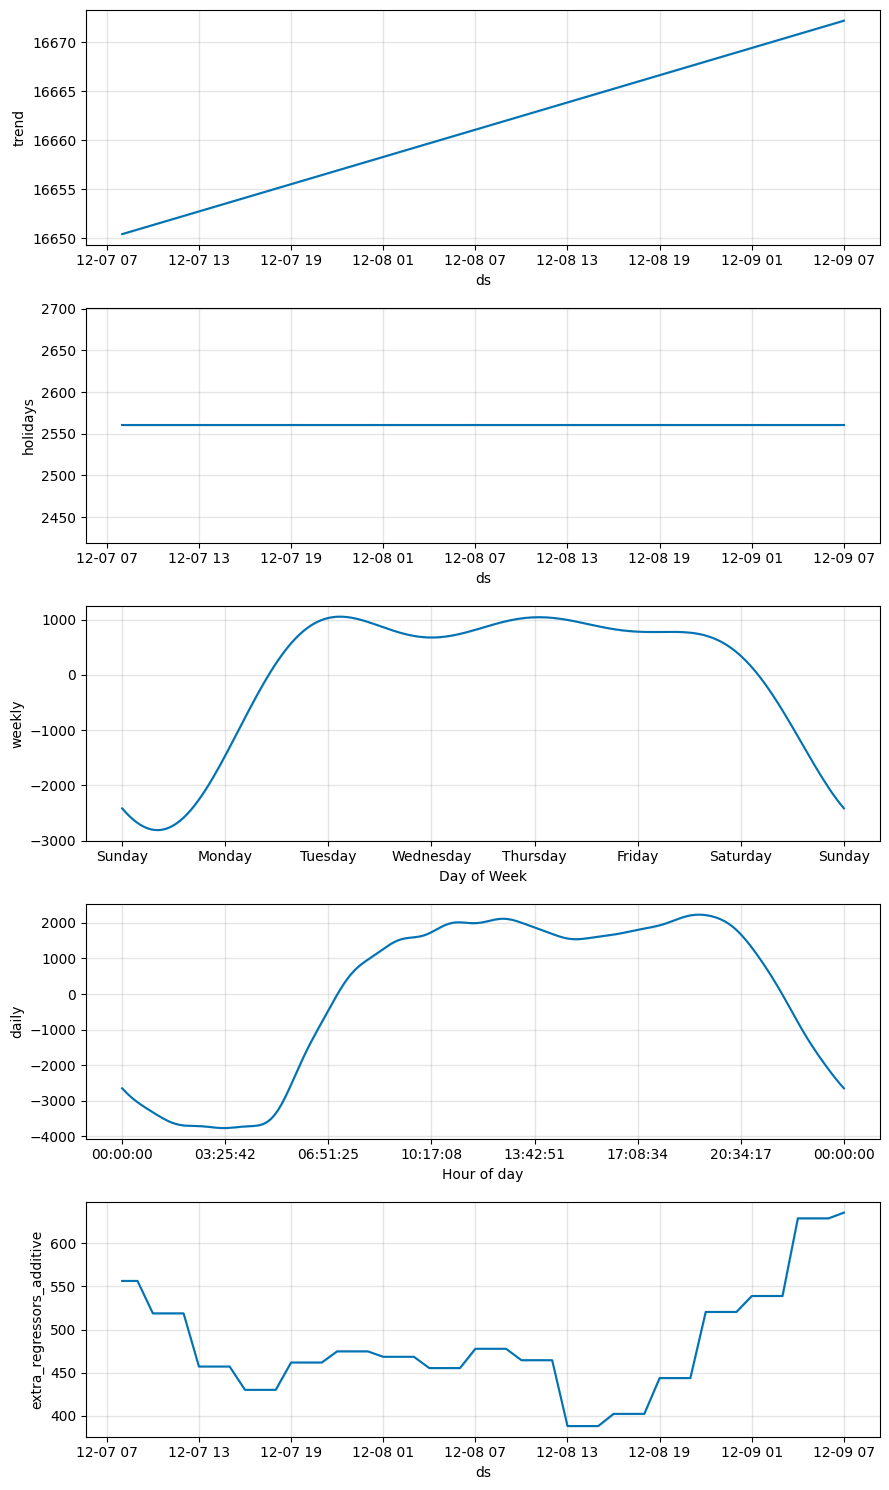

In [ ]:
print(model.plot_components(forecast_temp))

In [ ]:
rmse = np.sqrt(
    mean_squared_error(y_true=test_prophet["y"], y_pred=forecast_temp["yhat"])
)
print(f"RSME: {rmse:.1f} Mwh")

mae = mean_absolute_error(y_true=test_prophet["y"], y_pred=forecast_temp["yhat"])
print(f"MAE: {mae:.1f} Mwh")

mape = (
    mean_absolute_percentage_error(
        y_true=abs(test_prophet["y"]), 
        y_pred=forecast_temp["yhat"]
    )
    * 100
)
print(f"MAPE: {mape:.2f}%")

RSME: 1179.1 Mwh
MAE: 926.3 Mwh
MAPE: 4.45%


### Conclusion 

While there is an improvement in adding regressors, they are minimal and not worth predicting to add as regressors.

My champion model will be the Prophet model that has ONLY holidays added.


Here is the final eval metrics:

**MAE**: 819.56 Mwh
**MAPE**: 4.58%
